# Distribution Fitting

In this notebook, we will look at methods for fitting distributions to data using Python. In particular, we will look at both parametric and non-parametric distribution fitting methods. 

From https://en.wikipedia.org/wiki/Parametric_statistics (accessed 12/31/2018):
> Parametric statistics is a branch of statistics which assumes that sample data comes from a population that follows a probability distribution based on a fixed set of parameters. Most well-known elementary statistical methods are parametric. Conversely a non-parametric model differs precisely in that the parameter set (or feature set in machine learning) is not fixed and can increase, or even decrease if new relevant information is collected.
>
> Since a parametric model relies on a fixed parameter set, it assumes more about a given population than non-parametric methods do. When the assumptions are correct, parametric methods will produce more accurate and precise estimates than non-parametric methods, i.e. have more statistical power. However, as more is assumed by parametric methods, when the assumptions are not correct they have a greater chance of failing, and for this reason are not robust statistical methods. On the other hand, parametric formulae are often simpler to write down and faster to compute. For this reason their simplicity can make up for their lack of robustness, especially if care is taken to examine diagnostic statistics.

The parametric methods that we look at will attempt to estimate the parameters of a known empirical distribution from a data set. Essentially, we will define a set of known probability distributions, attempt to fit each one to a given data set, and then compare the errors associated with the various distribution fits to identify a single distribution that provides the closest approximation.

The non-parametric method that we will consider is known as kernel density estimation. Kernel density estimation works by centering a fixed *kernel function* at each data point that composes a data set. An example of a *kernel function* is a Normal distribution with mean equal to the data point value and a standard deviation of 1.0. Summing the kernal functions for all values in the sample space, and then normalizing the resulting sums results in a estimate of the probability distribution function for the data. The smoothness of the kernel density estimate (KDE) is controlled by the kernel function. For example, using a Normal distribution with a standard deviation of 2.0 will result in a smoother KDE than a Normal distribution with a standard deviation of 1.0.

Before discussing either approach to distribution fitting, we will first discuss the detection and removal of outliers from a data set. 

# Table of Contents
<a id="Table_of_Contents"> </a>

1. [Outlier Detection and Removal](#Outlier_Detection_and_Removal)<br>
2. [Parametric Distribution Fitting](#Parametric_Distribution_Fitting)<br>
3. [Non-Parametric Distribution Fitting](#nonParametric_Distribution_Fitting)<br>
4. [Putting it all together](#Putting_it_all_together)<br>

The following code block imports the Numpy and Matplotlib packages, which we will be using in this demonstration.

[Back to Table of Contents](#Table_of_Contents)<br>

The following code block imports packages that we will use to demonstrate parametric distribution fitting. In partiucular, we will largely rely on the capabilities provided by the `scipy.stats` module. From https://en.wikipedia.org/wiki/SciPy (accessed 12/31/2019):

> SciPy (pronounced "Sigh Pie") is a free and open-source Python library used for scientific computing and technical computing.
>
>SciPy contains modules for optimization, linear algebra, integration, interpolation, special functions, FFT, signal and image processing, ODE solvers and other tasks common in science and engineering.
>
>SciPy builds on the NumPy array object and is part of the NumPy stack which includes tools like Matplotlib, pandas and SymPy, and an expanding set of scientific computing libraries. This NumPy stack has similar users to other applications such as MATLAB, GNU Octave, and Scilab. The NumPy stack is also sometimes referred to as the SciPy stack.

[Back to Table of Contents](#Table_of_Contents)<br>

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st

The following code block uses Numpy to randomly generate a 500-point data set that follows a lognormal distribution. This data is plotted as a histogram. 

[Back to Table of Contents](#Table_of_Contents)<br>

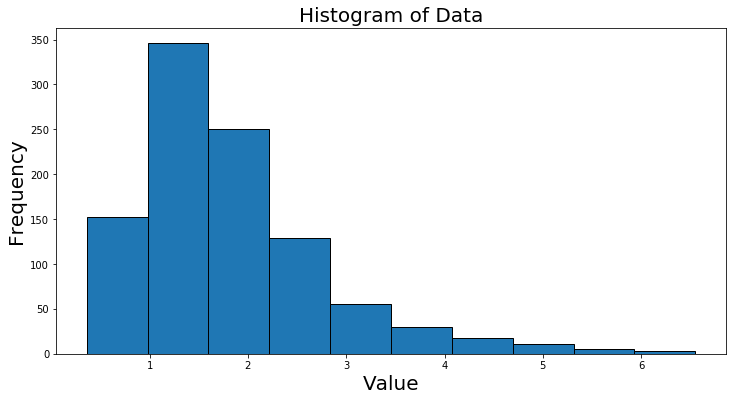

In [2]:
np.random.seed(0)
data  = np.random.lognormal(mean = 0.5, sigma = 0.5, size = 1000)

fig, ax = plt.subplots(1, 1, figsize = (12, 6))

ax.hist(data, edgecolor = 'k', label = 'Actual Data')
ax.set_ylabel('Frequency', fontsize = 20)
ax.set_xlabel('Value', fontsize = 20)
ax.set_title('Histogram of Data',  fontsize = 20)

plt.show()

## Outlier Detection and Removal
<a id="Outlier_Detection_and_Removal"> </a>

In this section, we will discuss the detection and removal of outliers from a data set. The most common approach for this purpose is the use of boxplots (see https://towardsdatascience.com/understanding-boxplots-5e2df7bcbd51 (accessed 2/27/2020) for additional discussion.

> Boxplots are a standardized way of displaying the distribution of data based on a five number summary ("minimum", first quartile (Q1), median, third quartile (Q3), and "maximum"), where
> - the median (Q2/50th Percentile) denotes the middle value of the dataset,
> - the first quartile (Q1/25th Percentile) denotes the middle number between the smallest number (not the "minimum") and the median of the dataset,
> - the third quartile (Q3/75th Percentile) denotes the middle value between the median and the highest value (not the "maximum") of the dataset,
> - the interquartile range (IQR) denotes the difference between the third and first quartiles,
> - the "maximum" is estimated as Q3 + 1.5(IQR), and
> - the "minimum" is estimated as Q1 -1.5(IQR).

Essentially, the boxlot calculations use the interquartile range (IQR) to approximate the variability associated with the data, and estimate the minimum and maximum values using multiples of the IQR. These estimations of the minimum and maximum values are not the smallest and largest values in the data. Instead, they are approximations for *reasonable* boundaries of the distribution. Any values that are less than or greater than these boundaries are flagged as outliers.

<div class="alert alert-block alert-danger">
    <b>Analysts should exercise extreme care when using boxplots to identify outliers when the underlying data is skewed. In particular, traditional boxplots implicitly assume that the underlying data is symmetric. If applied to skewed data, the traditional method for detecting outliers can lead to incorrectly identifying points as outliers.  
</div>
    
Given the sensitivity of the traditional approach for outlier detection to data skewness, we will employ the publised in Walker et al. (2018). In this research, the authors propose a new method for identifying outliers that is based on a statistic called Bowley’s Coefficient. Using this statistic, the authors devise a new approach for detecting outliers that is robust and better able to accommodate skewed data. The citation for the paper, which was published in *The American Statistician* is:

Walker, M. L., Dovoedo, Y. H., Chakraborti, S., & Hilton, C. W. (2018). An improved boxplot for univariate data. The American Statistician, 72(4), 348-353.

The following code block defines a function for handling outliers that defaults to the method described in Walker et al. (2018). However, it also allows users to force the assumption of symmetric data.

[Back to Table of Contents](#Table_of_Contents)<br>

In [3]:
def handle_outliers(data, outlier_threshold = 3.0, assume_symmetric = False, return_bool_array = False):
    '''
    This function removes outliers from a dataset that is structured
    as a 1-dimensional numpy array, pandas seriers, or list. In contrast
    to using traditional boxplots, the defualt for this function is based on 
    the outlier detection method described in Walker et al. (2018). A citation for
    the paper follows. In contrast to more traditional methods, this approach
    does not assume that the data is symmetric. If a user wants to force the
    assumption of symmetry, they may do so using the optional assume_symmetric
    argument. By default, the function returns a list that conatins the data
    with outliers removed. If the user wants to inspect the data points flagged
    as outliers, the return_bool_array argument may be specified to return a list
    of boolean values with True indicating that a point is NOT an outlier and
    False indicating that a point IS an outlier.
    
    The citation for the boxplot method employed for non-symmetric data is:
    Walker, M. L., Dovoedo, Y. H., Chakraborti, S., & Hilton, C. W. (2018). 
    An improved boxplot for univariate data. 
    The American Statistician, 72(4), 348-353.
    
    Arguments:
    data: a 1-dimensional numpy array, pandas series, or python list that 
    includes the data
    
    assume_symmetric: True or False to indicate whether or not the assumption
    of symmetrically distributed data should be enforced (default = False)
    
    return_bool_array: True or False to indicate whether or not to return a
    list of values with the outliers removed (False) or a list of boolean
    values where True indicates that a point is NOT an outlier and
    False indicates that a point IS an outlier
    
    Returns:
    By default, the function returns a list that conatins the data
    with outliers removed. If the user wants to inspect the data points flagged
    as outliers, the return_bool_array argument may be specified to return a list
    of boolean values with True indicating that a point is NOT an outlier and
    False indicating that a point IS an outlier.
             
    '''
    import numpy as np
    
    # Convert data to a numpy array
    data = np.array(data)     
        
    # calculate the 25th, 50th, and 75th percentiles    
    q1, q2, q3 = np.percentile(data, [25, 50, 75])
    
    # calculate the interquartile range
    IQR = q3 - q1
    
    # if user wants to force the assumption that
    # data is symmetric
    if assume_symmetric:
        
        # set ratios for lower and upper fences to 1
        RL = 1
        RU = 1
        
    # if user wants to use non-symmetric method
    else:    
        # Calculate Bowley’s Coefficient
        BC = (q3 + q1 - 2*q2)/(q3-q1)

        # Calculate ratio for lower fence
        RL = (1 - BC)/(1 + BC)
        
        # Calculate ratio for upper fence
        RU = (1 + BC)/(1 - BC)

    # compute upper and lower fences
    FL = q1 - outlier_threshold*IQR*RL
    FU = q3 + outlier_threshold*IQR*RU
        
    # Calculate values between lower and upper fences
    mask = np.logical_not((data >= FU) | (data <= FL))
    
    # if return_bool_array is True
    if return_bool_array:
        # return mask as a list
        return mask.tolist()
    
    else: 
        # return list of values with outliers removed
        return data[np.logical_not((data > FU) | (data < FL))].tolist()  

The following code block constructs a histogram that shows the original data along with the copies of the data that have outliers removed.

[Back to Table of Contents](#Table_of_Contents)<br>

In [4]:
from ipywidgets import interact
@interact(view = ['Data', 'Walker et al. (2018) Method', 'Traditional'])

def interactive_plot(view = 'Data'):
    
    view_dict = {'Data': data, 
                 'Walker et al. (2018) Method': handle_outliers(data), 
                 'Traditional': handle_outliers(data, assume_symmetric = True)}

    fig, ax = plt.subplots(1, 1, figsize = (12, 6))
    
    ax.hist(view_dict[view], 
            bins = np.linspace(0, 7, 25),
            edgecolor = 'k', 
            color = 'g')
    ax.set_xlabel('Value', fontsize = 15)
    ax.set_ylabel('Frequency', fontsize = 15)
    ax.set_title(f'Histogram for {view}', fontsize = 15)
    ax.set_xlim([0, data.max()+1])

    plt.show()

interactive(children=(Dropdown(description='view', options=('Data', 'Walker et al. (2018) Method', 'Traditiona…

## Parametric Distribution Fitting
<a id="Parametric_Distribution_Fitting"> </a>

This section looks at how we can use the SciPy library to for parametric distribution fitting. As stated earlier, parametric statistical techniques assume that a sample of data belongs to a larger population that follows a probability distribution that is based on a fixed set of parameters, e.g., a normal distribution with mean $\mu$ and standard deviation $\sigma$. Our approach to fitting distributions will be as follows:

1. Construct a histogram of the data,
2. Use the bin edges of the histogram to compute the midpoints of the bins,
3. Fit known probability distributions to the previously computed midpoints,
4. Calculate the sum-of-squares error between the fit from step 3 and the actal data,
5. Select a distibrution for use based on the computed errors.

[Back to Table of Contents](#Table_of_Contents)<br>

### Calculating Midpoints

Before continuing, let's look at how we can construct a histogram for a given data set and identify the midpoints of the bins. For the histogram construction, we will use NumPy's `histogram` method. For a provided set of data, this function returns a tuple that specifies the height of each bin and the bin edges. **Note that if we have $n$ bins, we will have $n+1$ bin edges**. Setting the `density` argument to `True` tells the method to normalize the values returned so that it resembles a probability density function.

The following code block executes the method on our sample data.

[Back to Table of Contents](#Table_of_Contents)<br>

In [5]:
y, x = np.histogram(data, bins = 'auto', density=True)

The values for each bin are given by printing the `y` object.

[Back to Table of Contents](#Table_of_Contents)<br>

In [6]:
y

array([0.08430365, 0.2482274 , 0.41683469, 0.58544199, 0.59480906,
       0.51987248, 0.42151823, 0.45430298, 0.23886033, 0.23417679,
       0.21544265, 0.15455668, 0.06088597, 0.11240486, 0.07493657,
       0.02341768, 0.0655695 , 0.02810122, 0.03746829, 0.02341768,
       0.01405061, 0.01405061, 0.01873414, 0.01873414, 0.00468354,
       0.00468354, 0.00468354, 0.        , 0.00936707])

Using the `len()` function, we can see how many values are included in the `y` object.

[Back to Table of Contents](#Table_of_Contents)<br>

In [7]:
len(y)

29

The values for each bin edge are given by printing the `x` object.

[Back to Table of Contents](#Table_of_Contents)<br>

In [8]:
x

array([0.35948906, 0.57300296, 0.78651686, 1.00003075, 1.21354465,
       1.42705855, 1.64057244, 1.85408634, 2.06760024, 2.28111413,
       2.49462803, 2.70814193, 2.92165582, 3.13516972, 3.34868362,
       3.56219752, 3.77571141, 3.98922531, 4.20273921, 4.4162531 ,
       4.629767  , 4.8432809 , 5.05679479, 5.27030869, 5.48382259,
       5.69733648, 5.91085038, 6.12436428, 6.33787817, 6.55139207])

As noted earlier, the number of bin edges returned exceeds the number of values by one.

[Back to Table of Contents](#Table_of_Contents)<br>

In [9]:
len(x)

30

To compute the midpoints for the bins, we need to essentially compute the midpoint of consecutive bin edges. We will use NumPy's `roll` method to perform this computation. The roll function essentially allows us to shift the values in a NumPy array by a specified amount. For example, the following code block shifts all values in the array one position earlier, with the first value *wrapping* around to the end.

[Back to Table of Contents](#Table_of_Contents)<br>

In [10]:
np.roll(x, -1)

array([0.57300296, 0.78651686, 1.00003075, 1.21354465, 1.42705855,
       1.64057244, 1.85408634, 2.06760024, 2.28111413, 2.49462803,
       2.70814193, 2.92165582, 3.13516972, 3.34868362, 3.56219752,
       3.77571141, 3.98922531, 4.20273921, 4.4162531 , 4.629767  ,
       4.8432809 , 5.05679479, 5.27030869, 5.48382259, 5.69733648,
       5.91085038, 6.12436428, 6.33787817, 6.55139207, 0.35948906])

Note that if we add the values of the original array to the shifted array and divide by two, we will obtain the bin midpoints in the $n-1$ positions of the summed array, where $n$ is the number of bin edges. This is shown in the following code block.

[Back to Table of Contents](#Table_of_Contents)<br>

In [11]:
(x + np.roll(x, -1)) / 2.0

array([0.46624601, 0.67975991, 0.8932738 , 1.1067877 , 1.3203016 ,
       1.53381549, 1.74732939, 1.96084329, 2.17435719, 2.38787108,
       2.60138498, 2.81489888, 3.02841277, 3.24192667, 3.45544057,
       3.66895446, 3.88246836, 4.09598226, 4.30949615, 4.52301005,
       4.73652395, 4.95003784, 5.16355174, 5.37706564, 5.59057954,
       5.80409343, 6.01760733, 6.23112123, 6.44463512, 3.45544057])

As noted, it is easy to see that the first value in the computed array is the midpoint between the first two bin edges returned by the `histogram` method. To remove the last value, we simple use NumPy array indexing to exclude the value as shown in the following code block.

[Back to Table of Contents](#Table_of_Contents)<br>

In [12]:
(x + np.roll(x, -1))[:-1] / 2.0

array([0.46624601, 0.67975991, 0.8932738 , 1.1067877 , 1.3203016 ,
       1.53381549, 1.74732939, 1.96084329, 2.17435719, 2.38787108,
       2.60138498, 2.81489888, 3.02841277, 3.24192667, 3.45544057,
       3.66895446, 3.88246836, 4.09598226, 4.30949615, 4.52301005,
       4.73652395, 4.95003784, 5.16355174, 5.37706564, 5.59057954,
       5.80409343, 6.01760733, 6.23112123, 6.44463512])

Note that the length of the computed array now matches the length of the values array returned by the `histogram` method.

[Back to Table of Contents](#Table_of_Contents)<br>

In [13]:
len((x + np.roll(x, -1))[:-1] / 2.0)

29

The following code block defines a function that uses the SciPy library, along with the previously desribed midpoint calculation approach to determine how well known probability distributions fit a provided data set. Comments in the function provide insight into what is happening. This function was largely motivated by the post found at https://stackoverflow.com/questions/6620471/fitting-empirical-distribution-to-theoretical-ones-with-scipy-python (accessed 1/1/2019).

[Back to Table of Contents](#Table_of_Contents)<br>

In [14]:
def fit_distributions(data, fit_all = False):
    '''
    This function fits all of the parametric distributions available
    in the scipy.stats module to a provided dataset, computes the 
    sum-of-squares error (SSE) for each distribution, and returns a
    dictionary that specifes the SSE, distribution parameters, and
    a frozen distribution generator for each distribution. The distribution 
    generator may be used with '.rvs()' method availble in scipy.stats to 
    generate a random sample.
    
    Arguments:
    data: a 1-dimensional list or Numpy array that includes the data
    
    fit_all: True or False to specify whether of not the function will
    attempt to fit all available distributions. If False, only a subset of
    common distributions are fit.
    
    Returns:
    data: a dictionary that specifes the SSE, distribution parameters, and
    a generator object for each distribution. The keys of the dictionary are
    the index values for each distribution when sorted by SSE. Thus, the 
    distribution associated with key 0 is the best fitting distribution.
         
        
    '''
    import warnings
    import numpy as np
    import scipy.stats as st
        
    # The following lines convert the data to a histogram and
    # compute the midpoints of the bins
    y, x = np.histogram(data, bins='auto', density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0
    
    # Initialize empty list for storing fit information
    dist_list = []
    dist_gen_list = []
    sse_list = []
    args_list = []

    # Distributions to check
    all_distributions = []
    if fit_all:   
        for this in dir(st):
            if ("fit" in eval("dir(st." + this +")")) and ("rvs" in eval("dir(st." + this +")")):
                all_distributions.append(this)
    else:
        for this in ['beta', 'chi2', 'erlang', 'expon', 'gamma', 'logistic',
                     'lognorm', 'norm', 'triang', 'truncnorm', 'uniform']:
            if ("fit" in eval("dir(st." + this +")")) and ("rvs" in eval("dir(st." + this +")")):
                all_distributions.append(this)

    # Estimate distribution parameters from data
    for dist_string in all_distributions:
        distribution = eval("st." + dist_string)
        
        sse = None
        args = None
        dist = None
        
        # Try to fit the distribution
        try:
                      
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                args = distribution.fit(data)
                dist = distribution.freeze(*args)

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, *args)
                sse = np.sum(np.power(y - pdf, 2.0))
        
        except:
            pass
        
        else:
            # Update lists
            dist_list.append(dist_string)
            sse_list.append(sse)
            args_list.append(args)
            dist_gen_list.append(dist)
            
    
    # Use the lists to construct a dictionary object        
    fit_comparison = zip(sse_list, dist_list, args_list, dist_gen_list)
    fit_comparison = sorted(fit_comparison)
    sse_list, dist_list, args_list, dist_gen_list = map(list, zip(*fit_comparison))
    
    
    fit_comparison = {index: {'Name': name, 
                              'Generator': gen, 
                              'SSE': sse, 
                              'Args': args} \
                      for index, (name, gen, sse, args) in enumerate(zip(dist_list, 
                                                                         dist_gen_list, 
                                                                         sse_list, 
                                                                         args_list))}

    return fit_comparison

The following code block executes the function for our data. The function returns a dictionary with the fit information, which is stored in the `fit_data` object.

[Back to Table of Contents](#Table_of_Contents)<br>

In [15]:
fit_data = fit_distributions(data)

The following code block prits the `fit_data` as a pandas `DataFrame` object for easier viewing. 

[Back to Table of Contents](#Table_of_Contents)<br>

In [16]:
pd.DataFrame.from_dict(fit_data, orient = 'index')

,Name,Generator,SSE,Args
0,lognorm,<scipy.stats._distn_infrastructure.rv_frozen o...,0.020958,"(0.5050249721795501, 0.032594053834314046, 1.5..."
1,gamma,<scipy.stats._distn_infrastructure.rv_frozen o...,0.035063,"(2.670622700646551, 0.32268115293052274, 0.561..."
2,chi2,<scipy.stats._distn_infrastructure.rv_frozen o...,0.035065,"(5.3411262775973665, 0.32268573429700653, 0.28..."
3,erlang,<scipy.stats._distn_infrastructure.rv_frozen o...,0.035066,"(2.6705401402607416, 0.32267909079235263, 0.56..."
4,beta,<scipy.stats._distn_infrastructure.rv_frozen o...,0.037293,"(2.5877631239674903, 2562447.920679391, 0.3295..."
5,logistic,<scipy.stats._distn_infrastructure.rv_frozen o...,0.154828,"(1.7010408590696802, 0.4978808931844634)"
6,norm,<scipy.stats._distn_infrastructure.rv_frozen o...,0.246029,"(1.82142637144286, 0.9550718960119234)"
7,truncnorm,<scipy.stats._distn_infrastructure.rv_frozen o...,0.344816,"(0.19636323277156187, 3.3619364720575122, -0.0..."
8,triang,<scipy.stats._distn_infrastructure.rv_frozen o...,0.415748,"(0.07465887886280713, 0.3317075772543868, 6.22..."
9,expon,<scipy.stats._distn_infrastructure.rv_frozen o...,0.626155,"(0.35948906217077126, 1.4619373092720886)"


As you can see, the function returns the fits in increasing order of sum-of-squares error (SSE). Thus, the first element (index 0) will always reference the fitted distribution with the lowest SSE. We can select the distribution that corresponds to the lowest sum-of-squares error (SSE) as shown in the next code block.

[Back to Table of Contents](#Table_of_Contents)<br>

In [17]:
print(f"A {fit_data[0]['Name']} distribution provides the lowest SSE of {fit_data[0]['SSE']}.")

A lognorm distribution provides the lowest SSE of 0.020957937108664303.


The `Generator` objects that are stored in the dictionary are SciPy generators that allow us to directly sample from the associated distribution. The following code block shows how we can use the generator object associated with the lowest SSE fit to generate a sample of 1000 data points. This sample is plotted along with the original data.

[Back to Table of Contents](#Table_of_Contents)<br>

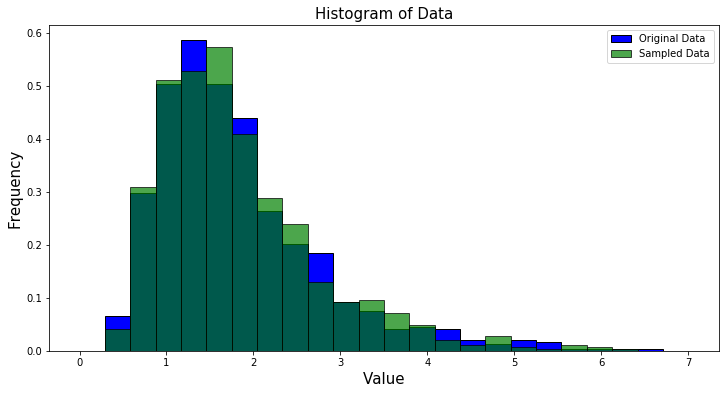

In [18]:
my_sample = fit_data[0]['Generator'].rvs(1000)

fig, ax = plt.subplots(1, 1, figsize = (12, 6))

ax.hist(data, 
        density = True, 
        bins = np.linspace(0, 7, 25), 
        edgecolor = 'k', 
        color = 'b', 
        label = 'Original Data')
ax.hist(my_sample, 
        density = True, 
        bins = np.linspace(0, 7, 25), 
        alpha = 0.7, 
        edgecolor = 'k', 
        color = 'g', 
        label = 'Sampled Data')
ax.set_xlabel('Value', fontsize = 15)
ax.set_ylabel('Frequency', fontsize = 15)
ax.legend()
ax.set_title('Histogram of Data', fontsize = 15)

plt.show()

## Non-Parametric Distribution Fitting
<a id="nonParametric_Distribution_Fitting"> </a>

We will now look at a non-parametric technique for approximating a a probability density function for a finite set of sample data that is known as kernel density estimation. As mentioned earlier, kernel density estimation works by centering a fixed *kernel function* at each data point that composes a data set. Summing the kernal functions for all values in the sample space, and then normalizing the resulting sums results in a estimate of the probability distribution function for the data. The smoothness of the kernel density estimate (KDE) is controlled by the kernel function.

We will demonstrate kernel density estimation using another set of randomly generated data that is multi-modal, i.e., it has multiple peaks. The following code block generates and plots the data set.

[Back to Table of Contents](#Table_of_Contents)<br>

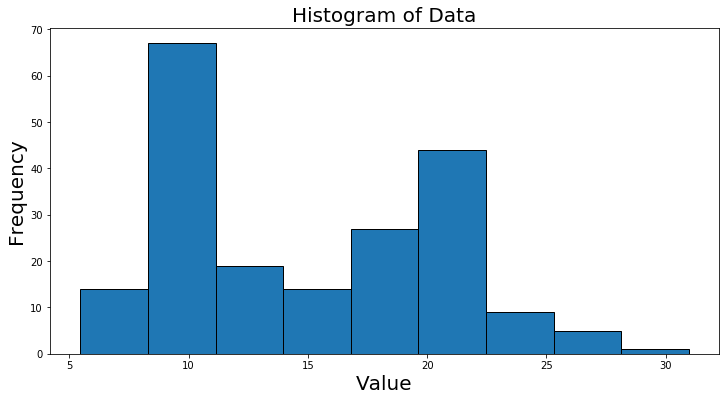

In [19]:
np.random.seed(42)
data = np.random.normal(loc = 10, scale = 1.5, size = 100)
data = np.append(data, np.random.normal(loc = 20, scale = 3, size = 100))
np.random.shuffle(data)

fig, ax = plt.subplots(1, 1, figsize = (12, 6))

ax.hist(data, 
        edgecolor = 'k',
        bins = np.linspace(data.min()*0.9, data.max()*1.1, 10),
        label = 'Actual Data')
ax.set_ylabel('Frequency', fontsize = 20)
ax.set_xlabel('Value', fontsize = 20)
ax.set_title('Histogram of Data',  fontsize = 20)

plt.show()

Before continuing, we define a convenience function that we will use throughout the remainder of this notebook. The function finds the minimum and maximum difference between any two consecutive values in a data set.

[Back to Table of Contents](#Table_of_Contents)<br>

In [20]:
def find_min_max_diff(data):
    '''
    This function finds the minimum and maximum difference between any
    two consecutive values in a data set
    
    Arguments
    data:
        a 1-dimensional list or Numpy array that includes the data
        
    Returns
    min_val, max_val: 
        a tuple specifiying the minimum and maximum difference between any
        two consecutive values in a data set
    
    '''
    
    import numpy as np
    
    data = np.array(data)
    
    data_copy = data.copy()
    data_copy = np.unique(data_copy)
    data_copy.sort()
    min_val = np.min(np.roll(data_copy, -1)[:-1] - data_copy[:-1])
    max_val =  np.max(np.roll(data_copy, -1)[:-1] - data_copy[:-1])
    
    return min_val, max_val 

The following code block demonstrates the use of the previously defined function.

[Back to Table of Contents](#Table_of_Contents)<br>

In [21]:
find_min_max_diff(data)

(2.4626661234705693e-05, 1.4652690773394692)

To motivate the intuition behind kernel density estimation, let's recall how histograms summarize a dataset. In particular, note how the number of bins we use affects our perception of the distribution for the underlying data. When a smaller number of wide bins are used, we obtain a *smoother* approximation for the distribution than we do if we use a use a larger number of narrower bins. This is demonstrated in the following code block that allows a user to vary the number of bins used to construct a histogram for the data.

[Back to Table of Contents](#Table_of_Contents)<br>

In [22]:
from ipywidgets import interact
@interact(bins=[1, 2, 3, 5, 10, 15, 20, 30, 40, 50, 100, 200, len(data)])

def interactive_plot(bins=1):
    fig, ax = plt.subplots(1, 1, figsize = (12, 6))

    ax.hist(data,  
            bins = bins, 
            edgecolor = 'k', 
            label = "Original Data")
    ax.set_xlabel('Value', fontsize = 15)
    ax.set_ylabel('Frequency', fontsize = 15)
    ax.legend()
    ax.set_title('Histogram of Data', fontsize = 15)

    plt.show()

interactive(children=(Dropdown(description='bins', options=(1, 2, 3, 5, 10, 15, 20, 30, 40, 50, 100, 200, 200)…

Instead of dividng the range of possible values into bins, suppose that we were to center a *Normal* (or *Gaussian*) distribution on each one of the data points in our sample, each with a standard deviation equal to 1.00. The following code block shows what would happen as we vary the number of points that we plot such curves on.

[Back to Table of Contents](#Table_of_Contents)<br>

In [23]:
@interact(points=[1, 2, 3, 5, 10, 20, 30, 100, len(data)])

def interactive_plot(points=1):

    X_plot = np.linspace(np.floor(np.min(data))*0.75, 
                         np.ceil(np.max(data))*1.1, 
                         20*int(np.ceil(np.max(data)))).reshape(-1,1)

    fig, ax = plt.subplots(1, 1, figsize=(12,6))

    samples = []
    sigma = 1.0
    for i in range(points):
        mu = data[i]
        new_sample = 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (X_plot - mu)**2 / (2 * sigma**2) )
        ax.plot(X_plot, new_sample)
        ax.set_xlabel("Value",fontsize = 16)
        ax.xaxis.set_tick_params(labelsize=16)
        ax.yaxis.set_tick_params(labelsize=16)
        ax.set_title(f'{points} Point(s) Shown',fontsize = 20)

    plt.show()

interactive(children=(Dropdown(description='points', options=(1, 2, 3, 5, 10, 20, 30, 100, 200), value=1), Out…

Now, instead of just plotting the individual distributions, what if we summed up the height of distributions overlapping for each value within the range of values.

[Back to Table of Contents](#Table_of_Contents)<br>

In [24]:
@interact(points=[1, 2, 3, 5, 10, 20, 30, 100, len(data)])

def interactive_plot(points=1):

    X_plot = np.linspace(np.floor(np.min(data))*0.75, 
                         np.ceil(np.max(data))*1.1, 
                         20*int(np.ceil(np.max(data)))).reshape(-1,1)

    fig, ax = plt.subplots(1, 1, figsize=(12,6))

    samples = []
    sigma = 1.0
    for i in range(points):
        mu = data[i]
        new_sample = 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (X_plot - mu)**2 / (2 * sigma**2) )
        samples.append(new_sample)
        ax.plot(X_plot, new_sample, linestyle='--', color='b')
        ax.set_xlabel("Value",fontsize = 16)
        ax.xaxis.set_tick_params(labelsize=16)
        ax.yaxis.set_tick_params(labelsize=16)
        ax.set_title(f'{points} Point(s) Shown',fontsize = 20)
    
    samples = np.array(samples)
    samples = samples.sum(axis = 0)
    ax.plot(X_plot, samples, color = 'k', linewidth=4)

    plt.show()

interactive(children=(Dropdown(description='points', options=(1, 2, 3, 5, 10, 20, 30, 100, 200), value=1), Out…

If we normalize this sum, we obtain an approximation for the relative frequency of the underlying data.

The following code block computes and plots the resulting approximation, which is a kernel density estimate (KDE) for the data that is based on a *gaussian* kernel with a *bandwidth* of 1.0. 

[Back to Table of Contents](#Table_of_Contents)<br>

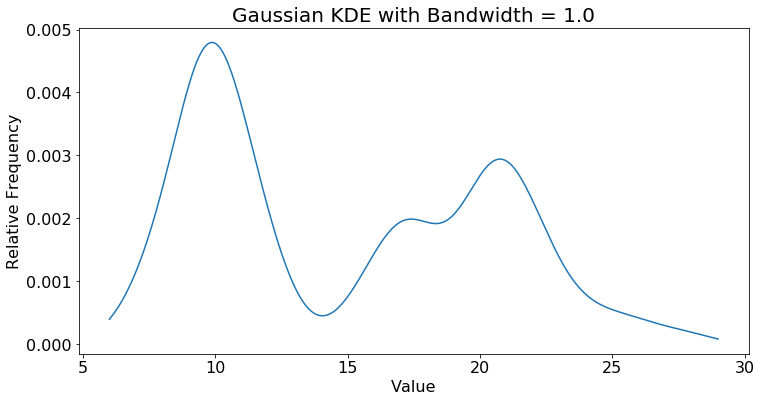

In [25]:
X_plot = np.linspace(np.floor(np.min(data)), 
                     np.ceil(np.max(data)), 
                     20*int(np.ceil(np.max(data)))).reshape(-1,1)

samples = []
sigma = 1.0
for i in range(len(data)):
    mu = data[i]
    new_sample = 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (X_plot - mu)**2 / (2 * sigma**2) )
    samples.append(new_sample)
    
samples = np.array(samples)
samples = samples.sum(axis = 0)
samples = samples/samples.sum()


fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(X_plot, samples)
ax.set_xlabel('Value',fontsize = 16)
ax.set_ylabel('Relative Frequency',fontsize = 16)
ax.set_title(f'Gaussian KDE with Bandwidth = {sigma}', fontsize = 20)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
plt.show()

Although the previous approximation bears some resemblance to our original data, it is clearly undersmoothed. The following code block shows how we can increase the smoothing by changing the standard deviation for the underlying gaussian curves that we plot at each data point. This is referred to as varying the *bandwidth* for the KDE.

[Back to Table of Contents](#Table_of_Contents)<br>

In [26]:
@interact(bandwidth=[0.1, 0.25, 0.5, 0.75, 1.00, 2.0, 3.0, 5.0, 10.0, 20.0, 100.0])

def interactive_plot(bandwidth = 0.1):

    X_plot = np.linspace(np.floor(np.min(data))*0.75, np.ceil(np.max(data))*1.1, 20*int(np.ceil(np.max(data)))).reshape(-1,1)

    samples = []
    sigma = bandwidth
    for i in range(len(data)):
        mu = data[i]
        new_sample = 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (X_plot - mu)**2 / (2 * sigma**2) )
        samples.append(new_sample)

    samples = np.array(samples)
    samples = samples.sum(axis = 0)
    samples = samples/samples.sum()


    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    ax.plot(X_plot, samples)
    ax.set_xlabel('Value',fontsize = 16)
    ax.set_ylabel('Relative Frequency',fontsize = 16)
    ax.set_title(f'Gaussian KDE with Bandwidth = {sigma}', fontsize = 20)
    ax.xaxis.set_tick_params(labelsize=16)
    ax.yaxis.set_tick_params(labelsize=16)
    plt.show()

interactive(children=(Dropdown(description='bandwidth', options=(0.1, 0.25, 0.5, 0.75, 1.0, 2.0, 3.0, 5.0, 10.…

Now that we understand the intuition behind kernel density estimation, we will now use the functionality offered in the *scikit-learn* package to automate the process. The following code block defines a function that uses *scikit-learn* to determine the best kernel type and bandwidth for approximating the distribution of a data set using a KDE.

[Back to Table of Contents](#Table_of_Contents)<br>

In [27]:
def fit_best_kde(data, steps = 25, rtol = 0.1, cv = 3, fit_sample_size = None):
    '''
    This function determines a best fitting kernel density estimate
    using scikit-learn's sklearn.neighbors.KernelDensity method along 
    scikit-learn's sklearn.model_selection.GridSearchCV method. In 
    particular, the GridSearchCV method is used to try all possible
    kernel types with 100 evenly spaced bandwidths between the minimum
    and maximum differences between values in the provided data.
    
    Arguments:
    data: a 1-dimensional list or Numpy array that includes the data
    
    rtol: the relative tolerance passed to sklearn.neighbors.KernelDensity 
    method. Higher values offer faster computational times at the cost of
    accuracy.
    
    cv: the number of cross-validation splits the sklearn.model_selection.GridSearchCV 
    method uses to identify the best kde.
    
    fit_sample_size: a value that, if specified, denotes that a random sample
    of size sample_size should be used to fit the kernel density estimate. This
    functionality is added to reduce the high computational times that may
    occur when the provided data is large.
    
    Returns:
    data: a dictionary specifes the best bandwidth and kernel.         
        
        
    '''
    import sklearn.neighbors as skneighbor
    from sklearn.model_selection import GridSearchCV
    import warnings
    import numpy as np
    
    data = np.array(data)
    
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        
        if fit_sample_size is not None:
            data = np.random.choice(data.ravel(), size = fit_sample_size, replace = False)

        min_val, max_val = find_min_max_diff(data)

        params = {'bandwidth': np.linspace(min_val, max_val, steps),
                 'kernel': skneighbor.kde.VALID_KERNELS}
        grid = GridSearchCV(skneighbor.KernelDensity(rtol = rtol), params, cv = cv)
        grid.fit(data.reshape(-1, 1))

        return grid.best_params_

The following code block executes the function on our data set and stores the returned data in an object named `best_params`.

[Back to Table of Contents](#Table_of_Contents)<br>

In [28]:
best_params = fit_best_kde(data)

The following code block prints the `best_params` object.

[Back to Table of Contents](#Table_of_Contents)<br>

In [29]:
best_params

{'bandwidth': 1.3431653731162831, 'kernel': 'tophat'}

The following code block defines a function that accepts the following arguments:
1. a data set,
2. a minimum value (by default, no value is specified),
3. a maximum value (by default, no value is specified),
4. a bandwidth value (defaults to 1.0),
5. a kernel type (defaults to gaussian).

It uses these arguments to generate a probability density function for the specified KDE.

[Back to Table of Contents](#Table_of_Contents)<br>

In [30]:
def pdf_from_kde(data, min_val = 0, max_val = None, bandwidth = 1.0, kernel = 'gaussian'):
    '''
    This function generates a probability density function (PDF) that is 
    based on a kernel density estimate that is fit using scikit-learn's
    sklearn.neighbors.KernelDensity method. Specifically, it returns two
    objects, pdfx and pdfy, that contain the support and probability values
    that define the PDF, respectively. 
    
    Arguments:
    data: a 1-dimensional list or Numpy array that includes the data
    
    min_val: the minimum value to include in the PDF support (default
    is min_value - 0.10*[range between max_val and min_val values])
    
    max_val: the maximum value to include in the PDF support (default
    is max_value + 0.10*[range between max_val and min_val values])
    
    bandwidth: the bandwidth for the kernel density estimate.
    
    cv: the kernel type, which is passed directly to scikit-learn's
    sklearn.neighbors.KernelDensity method
    
    Returns:
    data: a dictionary with two keys, x and y. The values are NumPy arrays for the 
    support (x) and probability values (y) that define the PDF.
        
        
    '''

    import sklearn.neighbors as skneighbor
    import numpy as np
    
    data = np.array(data)
        
    if min_val is None:
        min_val = data.min() - 0.10*(data.max() - data.min())
        
    if max_val is None:
        max_val = data.max() + 0.10*(data.max() - data.min())

    pdfx = np.linspace(min_val, max_val, 1000)
    pdfy = np.exp(skneighbor.KernelDensity(bandwidth = bandwidth, 
                                           kernel= kernel,
                                           rtol = 0.1).fit(data.reshape(-1,1)).score_samples(pdfx.reshape(-1,1)))
    pdfy = pdfy/pdfy.sum()
    return {'x': pdfx, 'y': pdfy}

The following code block uses `pdf_from_kde` to generate a probability density function based on the best KDE that we identifed using the `fit_best_kde` function. The probability density function is plotted.

[Back to Table of Contents](#Table_of_Contents)<br>

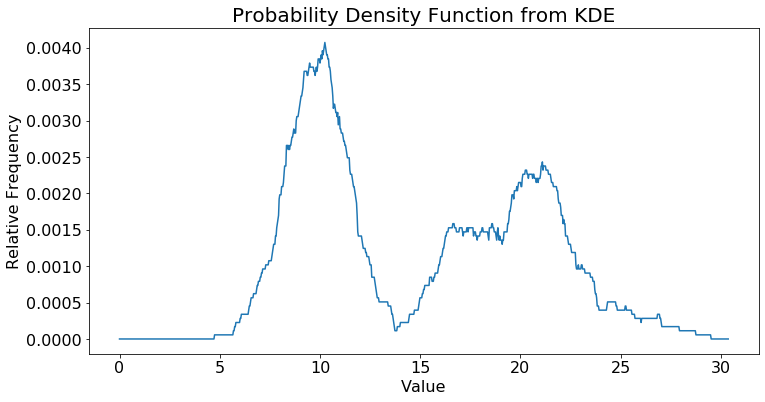

In [31]:
pdf = pdf_from_kde(data, 
                   bandwidth = best_params['bandwidth'], 
                   kernel = best_params['kernel'])

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(pdf['x'], pdf['y'])
ax.set_xlabel('Value',fontsize = 16)
ax.set_ylabel('Relative Frequency',fontsize = 16)
ax.set_title(f'Probability Density Function from KDE', fontsize = 20)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
plt.show()

Finally, we may wish to generate a random data sample using the KDE. The following `trunc_kde_sample` function accepts the probability density function information returned by our `pdf_from_kde` object for such purposes. 

Given the way that kernel density estimation works, it can be the case that the probability density function that results from using the technique is defined for values that are not valid. For example, it may be defined for negative values when this is not possible in reality. The `trunc_kde_sample` allows a user to specify reasonable minimum and maximum values, as well as the sample size, to make sure that the generated sample includes valid values.

[Back to Table of Contents](#Table_of_Contents)<br>

In [32]:
def trunc_kde_sample(pdfx, pdfy, low = None, high = None, sample_size = 100, seed = 0):
    '''
    This function requires two array-like data objects, pdfx and pdfy,
    that specify the support and probabilities for a probability density
    function (PDF) defined by a kernel density estimate (see the 
    pdf_from_kde function). These data objects are used to generate a sample
    from the defined PDF that falls between optional lower and upper bounds.
    
    Arguments:
    pdfx: a 1-dimensional list or Numpy array that specifies the PDF's support
    
    pdfy: a 1-dimensional list or Numpy array that specifies the probability
    for each value in the PDF's support
    
    low: the lower bound for values in the generated sample
    
    high: the upper bound for values in the generated sample
    
    sample_size: the size of the sample to be drawn (1-dimensional only)
    
    seed: seed for Numpy's random number generator
    
    Returns:
    gen_sample: the generated sample as a Numpy array.
        
        
    '''
    import numpy as np
    
    pdfx = np.array(pdfx)    
    pdfy = np.array(pdfy)
    
    if (low != None) and (high != None):
        mask = pdfx >= low
        pdfx = pdfx[mask]
        pdfy = pdfy[mask]
        
        mask = pdfx <= high
        pdfx = pdfx[mask]
        pdfy = pdfy[mask]
        
    elif (low != None):
        mask = pdfx >= low
        pdfx = pdfx[mask]
        pdfy = pdfy[mask]
        
    elif (high != None):
        mask = pdfx <= high
        pdfx = pdfx[mask]
        pdfy = pdfy[mask]
        
    pdfy = pdfy/pdfy.sum()
    cdf = pdfy.cumsum()
    cdf = cdf - cdf.min()
    
    np.random.seed(seed)
    random_nums = np.random.rand(sample_size)
    gen_sample = []
    for i in random_nums:
        gen_sample.append(pdfx[(cdf < i).argmin() - 1])
    
    return np.array(gen_sample)

The following code block demonstrates the use of the `trunc_kde_sample` function.

[Back to Table of Contents](#Table_of_Contents)<br>

In [33]:
my_sample = trunc_kde_sample(pdf['x'], pdf['y'], low = 0, sample_size = 500000)

The following code block plots the sampled data along with the original sample.

[Back to Table of Contents](#Table_of_Contents)<br>

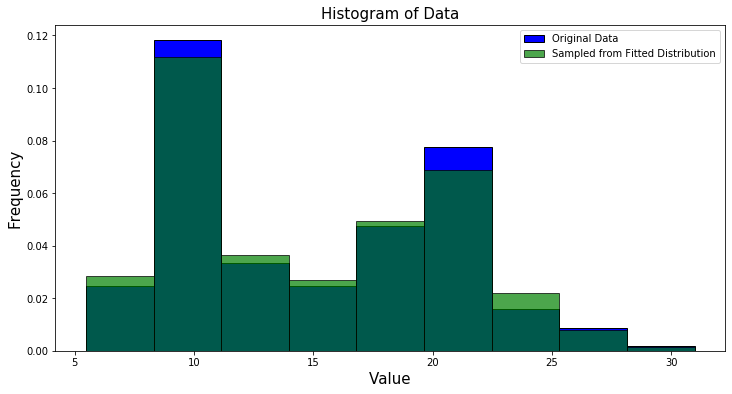

In [34]:
fig, ax = plt.subplots(1, 1, figsize = (12, 6))

ax.hist(data, 
        density = True, 
        bins = np.linspace(data.min()*0.9, data.max()*1.1, 10), 
        edgecolor = 'k', 
        color = 'b', 
        label = "Original Data")
ax.hist(my_sample, 
        density = True, 
        bins = np.linspace(data.min()*0.9, data.max()*1.1, 10), 
        alpha = 0.7, 
        edgecolor = 'k', 
        color = 'g', 
        label = "Sampled from Fitted Distribution")
ax.set_xlabel('Value', fontsize = 15)
ax.set_ylabel('Frequency', fontsize = 15)
ax.legend()
ax.set_title('Histogram of Data', fontsize = 15)

plt.show()

##  Putting it all together
<a id="Putting_it_all_together"> </a>

Just as an illustration, we will now use the developed function to fit parametric and non-parametric distributions to a set of data and generate samples with minimal code. The following code block generates a new data set for this demonstration.

[Back to Table of Contents](#Table_of_Contents)<br>

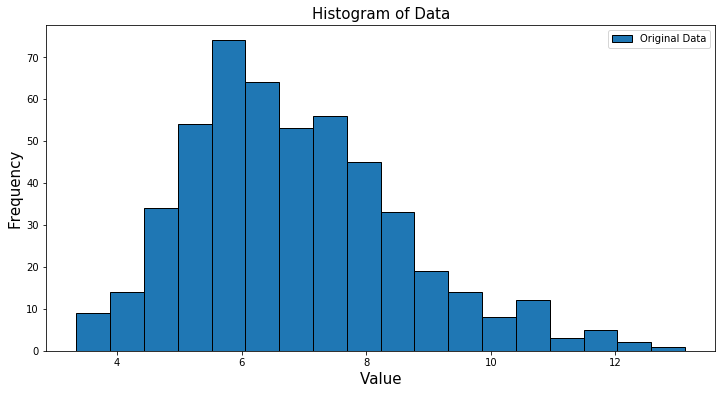

In [35]:
np.random.seed(0)
data  = np.random.lognormal(mean=1.9, sigma = 0.25, size = 500)

fig, ax = plt.subplots(1, 1, figsize = (12, 6))

ax.hist(data,  
        bins = 'auto', 
        edgecolor = 'k', 
        label = "Original Data")
ax.set_xlabel('Value', fontsize = 15)
ax.set_ylabel('Frequency', fontsize = 15)
ax.legend()
ax.set_title('Histogram of Data', fontsize = 15)

plt.show()

The following code block uses the parametric approach for fitting a distribution and generating a sample of 1000 data points from the best fitting distribution. The sample is plotted along with the original data.

[Back to Table of Contents](#Table_of_Contents)<br>

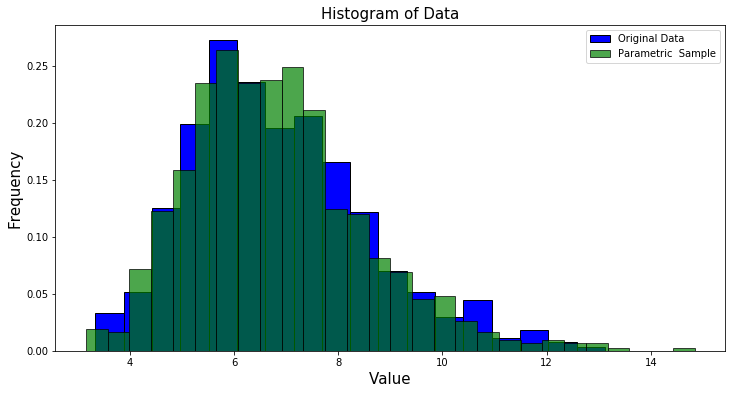

In [36]:
fit_data = fit_distributions(data)
my_parametric_sample = fit_data[0]['Generator'].rvs(1000)

fig, ax = plt.subplots(1, 1, figsize = (12, 6))
ax.hist(data,  
        bins = 'auto', 
        edgecolor = 'k', 
        color = 'b',
        density = True,
        label = 'Original Data')
ax.hist(my_parametric_sample,  
        bins = 'auto', 
        edgecolor = 'k',
        color = 'g',
        density = True,
        alpha = 0.7,
        label = 'Parametric  Sample')
ax.set_xlabel('Value', fontsize = 15)
ax.set_ylabel('Frequency', fontsize = 15)
ax.legend()
ax.set_title('Histogram of Data', fontsize = 15)

plt.show()

The following code block uses the non-parametric approach for fitting a distribution and generating a sample of 1000 data points. The sample is plotted along with the original data and the sample generated using parameteric methods.

[Back to Table of Contents](#Table_of_Contents)<br>

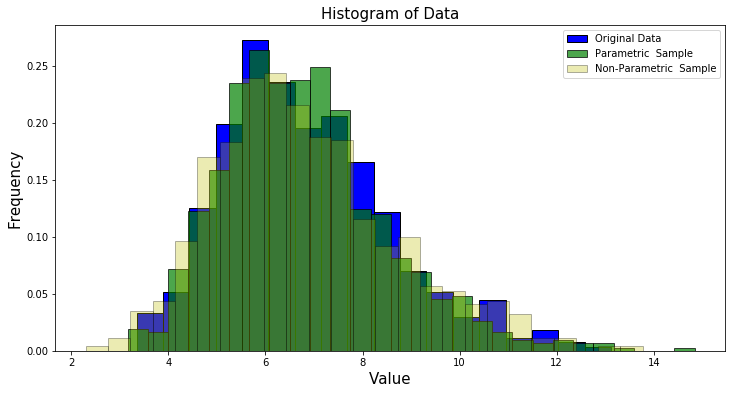

In [37]:
best_params = fit_best_kde(data)
pdf = pdf_from_kde(data, 
                   bandwidth = best_params['bandwidth'], 
                   kernel = best_params['kernel'])
my_nonparametric_sample = trunc_kde_sample(pdf['x'],
                                           pdf['y'], 
                                           low = 0, 
                                           sample_size = 1000)

fig, ax = plt.subplots(1, 1, figsize = (12, 6))
ax.hist(data,  
        bins = 'auto', 
        edgecolor = 'k', 
        color = 'b',
        density = True,
        label = 'Original Data')
ax.hist(my_parametric_sample,  
        bins = 'auto', 
        edgecolor = 'k',
        color = 'g',
        density = True,
        alpha = 0.7,
        label = 'Parametric  Sample')
ax.hist(my_nonparametric_sample,  
        bins = 'auto', 
        edgecolor = 'k',
        color = 'y',
        density = True,
        alpha = 0.3,
        label = 'Non-Parametric  Sample')
ax.set_xlabel('Value', fontsize = 15)
ax.set_ylabel('Frequency', fontsize = 15)
ax.legend()
ax.set_title('Histogram of Data', fontsize = 15)

plt.show()

Clearly, both approaches are able to provide reasonable approximations to the data.

[Back to Table of Contents](#Table_of_Contents)<br>